# Opening
The goal of this pet project is to experiment with building recommendation engines for video games purchases.
The data used are 2 Steam dataset, one of which contains data on users, what games they bought and how many hours they palyed.\
The other contains info on the games, like generes, tags, publishers etc.

The project will is diveded into 3 parts:\
Part 1 is basic yet comprehensive analysis focusing on understanding both datasets, building classification models (which are proto-rec_engines) and playing with basic feature generation.\
In **Part 2** we will try to tackle the imbalanced classes problems and generate more features from text values\
In Part 3 we will use collaborative filtering to build our recoomender engine

Let's import some libs

In [1]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import colorlover as cl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler    
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
import scipy.stats as ss
from catboost import CatBoostClassifier, Pool
import catboost as cb
import sys

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
RANDOM_SEED = 42

Next steps basically repeat what we did in **Part 1**, with minor changes

In [5]:
all_games = pd.read_csv('steam_games.csv')
all_games.head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN


In [6]:
all_games.drop(['url', 'minimum_requirements', 'recommended_requirements', 'languages', 'types'], axis = 1, inplace = True)

In [7]:
all_games['recent_reviews'] = all_games['recent_reviews'].str.split(',', expand = True)
all_games['all_reviews'] = all_games['all_reviews'].str.split(',', expand = True)
all_games['publisher'] = all_games['publisher'].str.split(',', expand = True)

In [8]:
all_games['achievements'] = all_games['achievements'].fillna(0)

In [9]:
all_games['original_price'] = pd.to_numeric(all_games['original_price'].str.strip('$'), errors='coerce').fillna(0.0)

In [10]:
all_games['discount_price'] = pd.to_numeric(all_games['discount_price'].str.strip('$'), errors='coerce').fillna(0.0)

In [11]:
all_games = all_games.join(all_games['popular_tags'].str.split(',', expand=True).add_prefix('tag')).drop(['tag5','tag6', 'tag7', 'tag8',
                                                                                             'tag9', 'tag10', 'tag11', 'tag12',
                                                                                             'tag13', 'tag14', 'tag15', 'tag16',
                                                                                             'tag17', 
                                                                                              'tag18', 'tag19'], axis =1).fillna(value='nan')

In [12]:
all_games.drop(['popular_tags'], axis =1, inplace = True)

In [13]:
all_games = all_games.join(all_games['game_details'].str.split(',', expand=True).add_prefix('detail')).drop(['detail5', 'detail6', 'detail7',
                                                                                                'detail8','detail9', 'detail10', 
                                                                                                 'detail11', 'detail12', 'detail13',
                                                                                                'detail14', 'detail15',
                                                                                                'detail16', 'detail17', 'detail18',
                                                                                                'detail19', 'detail20',
                                                                                                'detail21'], axis = 1).fillna(value ='nan')

In [14]:
all_games.drop(['game_details'], axis = 1, inplace = True)

In [15]:
bins_price = [0, 1, 5, 10, 15, 30, 50, 100, 1001]
labels_price =['Free','Under 5 USD','Under 10 USD','Under 15 USD', 'Under 30 USD', 'Under 50 USD', 'Under 100 USD', "Under 1000 USD"]
all_games['binned_price'] = pd.cut(all_games['original_price'], bins_price,labels=labels_price, include_lowest = True)

In [16]:
all_games['discount'] = 100 - (all_games['discount_price'] / all_games['original_price']*100).fillna(0)

In [17]:
all_games['discount'].replace([100], [0])

0        25.012506
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
40828     0.000000
40829     0.000000
40830     0.000000
40831     0.000000
40832    43.887776
Name: discount, Length: 40833, dtype: float64

In [18]:
bins_discount = [0,1,25,50,75,101]
labels_discount =['No discount', 'Up to 25%', "Up to 50%", 'Up to 75%', 'Up to 100%']
all_games['binned_discount'] = pd.cut(all_games['discount_price'], bins_discount,labels=labels_discount, include_lowest = True)

In [19]:
bins_achievements = [0,1,5,10,15,20,50,100,1000]
labels_achievements = ['No achievemnts', 'Up to 5 achievements', 'Up to 10 achievements', 'Up to 15 achievemnts', 
                      'Up to 20 achievemnts', 'Up to 50 achivements', 'Up to 100 achivements', 'Up to 1000 achievemnets']

In [20]:
all_games['binned_achievements'] = pd.cut(all_games['discount_price'], bins_achievements,labels=labels_achievements, include_lowest = True)

In [21]:
reviews_to_keep = ['Mixed', 'Very Positive', 'Positive', 'Mostly Positive', 
                  'Mostly Negative', 'Overwhelmingly Positive', 'Negative', 'Very Negative',
                  'Overwhelmingly Negative']

In [22]:
all_games['all_reviews'] = all_games['all_reviews'][all_games.all_reviews.isin(reviews_to_keep)]

In [23]:
all_games.dropna(subset = ["all_reviews"], inplace=True)

In [24]:
all_games['all_reviews'] = all_games['all_reviews'].replace({'Mostly Positive':'Positive', 'Very Positive':'Positive', 'Positive':'Positive',
                'Overwhelmingly Positive':'Positive', 'Negative ': 'Negative ', 
                'Mostly Negative':'Negative', 'Very Negative': "Negative", 'Overwhelmingly Negative' : 'Negative',
                "mixed": "mixed"})

In [25]:
all_games = all_games.join(all_games['genre'].str.split(',', expand=True).add_prefix('genre'))

In [26]:
all_games.drop(['genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10','genre11', 
                'genre12'], axis = 1, inplace = True)

In [27]:
all_games.drop(['genre'], axis = 1, inplace = True)

In [28]:
all_games.drop(['achievements', 'discount', 'original_price'], axis = 1, inplace = True)

In [29]:
all_games['release_date'] = pd.to_datetime(all_games['release_date'], errors = 'coerce')

In [30]:
all_games.head()

,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,game_description,mature_content,discount_price,...,detail1,detail2,detail3,detail4,binned_price,binned_discount,binned_achievements,genre0,genre1,genre2
0,DOOM,Now includes all three premium DLC packs (Unto...,Very Positive,Positive,2016-05-12,id Software,Bethesda Softworks,"About This Game Developed by id software, the...",nan,14.99,...,Multi-player,Co-op,Steam Achievements,Steam Trading Cards,Under 30 USD,Up to 25%,Up to 15 achievemnts,Action,None,None
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,Mixed,Mixed,2017-12-21,PUBG Corporation,PUBG Corporation,About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,0.00,...,Online Multi-Player,Stats,nan,nan,Under 30 USD,No discount,No achievemnts,Action,Adventure,Massively Multiplayer
2,BATTLETECH,Take command of your own mercenary outfit of '...,Mixed,Positive,2018-04-24,Harebrained Schemes,Paradox Interactive,About This Game From original BATTLETECH/Mec...,nan,0.00,...,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Under 50 USD,No discount,No achievemnts,Action,Adventure,Strategy
3,DayZ,The post-soviet country of Chernarus is struck...,Mixed,Mixed,2018-12-13,Bohemia Interactive,Bohemia Interactive,About This Game The post-soviet country of Ch...,nan,0.00,...,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Under 50 USD,No discount,No achievemnts,Action,Adventure,Massively Multiplayer
4,EVE Online,EVE Online is a community-driven spaceship MMO...,Mixed,Positive,2003-05-06,CCP,CCP,About This Game,nan,0.00,...,Online Multi-Player,MMO,Co-op,Online Co-op,Free,No discount,No achievemnts,Action,Free to Play,Massively Multiplayer


Last time we dropped datetime features, now we kept them. Let's see if anything can be derived from them

In [31]:
plot_data = all_games[['release_date', 'all_reviews']]

In [32]:
plot_data = (plot_data.reset_index()
          .groupby(['release_date','all_reviews'], as_index=False)
          .count()
       )

In [33]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from plotly import tools

In [34]:
positive = go.Scatter(
                x=plot_data.release_date,
                y=plot_data[plot_data['all_reviews'] == 'Positive'].count(),
                name = "Positive reviews",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

negative = go.Scatter(
                x=plot_data.release_date,
                y=plot_data[plot_data['all_reviews'] == 'Negative'].count(),
                name = "Negative reviews",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [positive, negative]

layout = dict(
    title = "Reviews by date"
)
fig = dict(data=data, layout=layout)
py.offline.plot(fig, filename='reviews-by-date.html')

'reviews-by-date.html'

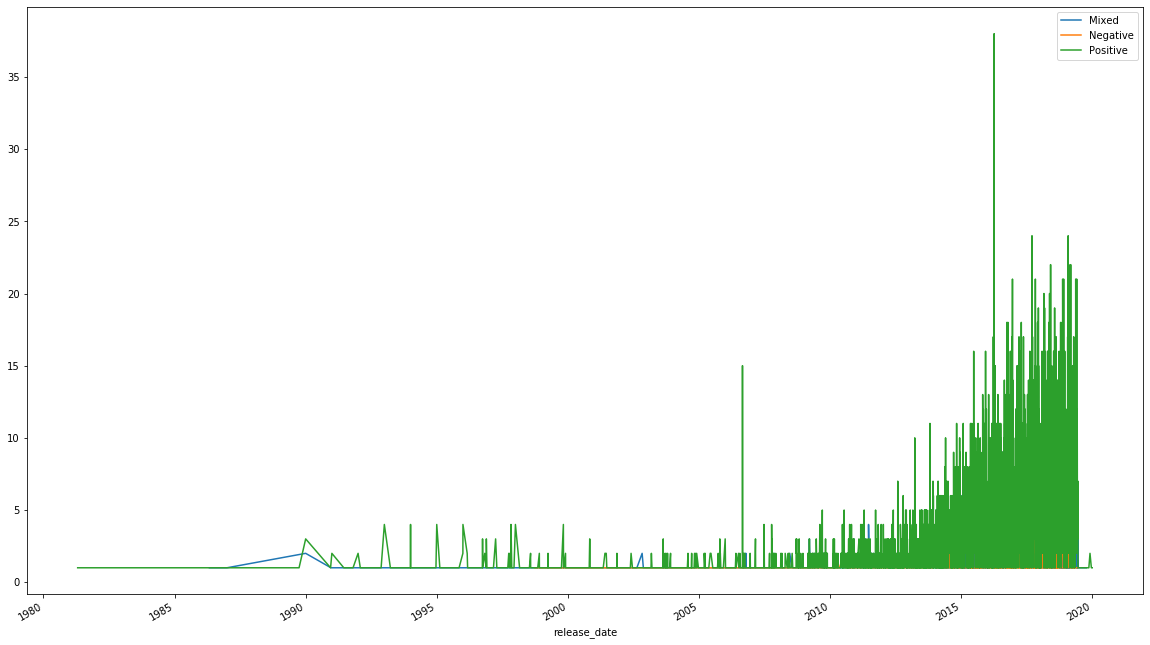

In [35]:
fig, ax = plt.subplots()

# key gives the group name (i.e. category), data gives the actual values
for key, data in plot_data.groupby('all_reviews'):
    data.plot(x='release_date', y='index', ax=ax, label=key, figsize=(20, 12))

Not very infromative, due to imbalanced classes

## Text features extarction
He we will try different approaches:
1. Basic features like length of sentences
2. TfIDF vectorizing
3. Separately, we will build some topic modelling on text columsn

In [37]:
import nltk

Basic text transformation

In [38]:
all_games['name'] = all_games['name'].str.lower()

In [39]:
all_games['desc_snippet'] = all_games['desc_snippet'].str.lower()

In [40]:
all_games['game_description'] = all_games['game_description'].str.lower()

In [41]:
all_games['mature_content'] = all_games['mature_content'].str.lower()

In [42]:
all_games['game_description'] = all_games['game_description'].map(lambda x: x.lstrip('about this game').rstrip('aAbBcC'))

In [43]:
all_games['mature_content'] = all_games['mature_content'].map(lambda x: x.lstrip('mature content').rstrip('aAbBcC'))

In [44]:
all_games['mature_content'] = all_games['mature_content'].map(lambda x: x.lstrip('description').rstrip('aAbBcC'))

In [45]:
all_games['mature_content'] = all_games['mature_content'].map(lambda x: x.lstrip('the developers describe the content like this').rstrip('aAbBcC'))

Removing stopwords

In [46]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

In [47]:
all_games['desc_snippet'] = all_games['desc_snippet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [48]:
all_games['game_description'] = all_games['game_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [49]:
all_games['mature_content'] = all_games['mature_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [50]:
all_games['desc_snippet']

0        includes premium dlc packs (unto evil, hell fo...
1        playerunknown's battlegrounds battle royale sh...
2        command mercenary outfit 'mechs mechwarriors p...
3        post-soviet country chernarus struck unknown v...
4        eve online community-driven spaceship mmo play...
                               ...                        
40557    dance tango death grabity, fast-paced, physics...
40598    detached, suspenseful interstellar duel demand...
40611    solve mysterious criminal case dark pixel-styl...
40728    chasing stars steampunk-ish multichoice bl vis...
40811    book nanoui stolen, plunging kingdom chaos all...
Name: desc_snippet, Length: 17363, dtype: object

In [52]:
all_games['desc_snippet']

0        includes premium dlc packs (unto evil, hell fo...
1        playerunknown's battlegrounds battle royale sh...
2        command mercenary outfit 'mechs mechwarriors p...
3        post-soviet country chernarus struck unknown v...
4        eve online community-driven spaceship mmo play...
                               ...                        
40557    dance tango death grabity, fast-paced, physics...
40598    detached, suspenseful interstellar duel demand...
40611    solve mysterious criminal case dark pixel-styl...
40728    chasing stars steampunk-ish multichoice bl vis...
40811    book nanoui stolen, plunging kingdom chaos all...
Name: desc_snippet, Length: 17363, dtype: object

## Topic modelling
Here we will use TfIdf vectorizing, which tehn will act as an input to three different models:
1. NMF with Frobenius norm
2. NMF with KL divergence
3. Latent Dirichle Allocation\
We will vizualize top-10 topics using each model on each of text columns - desc_snippet, gane_description and mature_content

**desc_snippet**

In [54]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


n_features = 1000
n_components = 10
n_top_words = 20
n_samples = 3000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
data_samples = all_games['desc_snippet']
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.357s.
Extracting tf features for LDA...
done in 0.341s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3000 and n_features=1000...
done in 0.924s.

Topics in NMF model (Frobenius norm):
Topic #0: nan zombies fate fights fighting fighter fight field fiction fi feel featuring features fear favorite father faster final fast farm
Topic #1: action shooter fast play multiplayer paced fight players way arcade battle enemies online friends space weapons player person platformer combat
Topic #2: game play horror games player players video simple music simulation card strategy playing like different style indie multiplayer 3d modes
Topic #3: adventure story life novel visual horror journey mysterious love dark help puzzles young mystery girl set explore discover point solve
Topic #4: world open explore war set save fantasy evil build enter magic power journey survive welcome discover beaut

Interesting, NMF detected the following games "kinds" as top:
1. Zombie related (of course! it's a trend)
2. Fast paced action and shooters
3. Multiplayer oriented
4. Horror games
5. Adventures and interactive novels
6. Both RTS and TBS
7. Puzzles and platfromers
8. VR 

LDA, however, put strategy games on top, other top topics are roughly same



**game_description**

In [56]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
data_samples = all_games['game_description']
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 1.753s.
Extracting tf features for LDA...
done in 1.717s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3000 and n_features=1000...
done in 1.674s.

Topics in NMF model (Frobenius norm):
Topic #0: game players play mode player multiplayer online games friends modes team time free like create single local fun make want
Topic #1: new brand expansion content including city campaign dlc improved series original adds challenges experience features missions map buildings enhanced added
Topic #2: story world adventure life game explore puzzles characters time dark mysterious help solve journey way discover hidden secrets people make
Topic #3: content pack dlc includes character contains exclusive weapon pass season included following access additional characters menu 10 edition adds soundtrack
Topic #4: car racing cars race tracks track driving vehicles road world engine physics vehicle 

Here NMF put multiplayer oriented games on top, followed by story reach games and content reach games, while LDA put sapce themed games on the first place fllowd by actions, adventures and startegies

**mature_content**

In [58]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
data_samples = all_games['mature_content']
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.059s.
Extracting tf features for LDA...
done in 0.059s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3000 and n_features=1000...
done in 0.496s.

Topics in NMF model (Frobenius norm):
Topic #0: appropriate content game ages viewing contain work general mature frequent nudity demo suitable cruelty completely setting threat war suicide disabled
Topic #1: gore violence frequent appropriate mature general work ages viewing contain cartoon depictions graphic pixelated content realistic pixel like optional included
Topic #2: sexual nudity content acts mild partial explicit adult consensual non fantasy sex assault implied nuidity mature interactions dialog cgs version
Topic #3: appropriate content dlc general viewing work ages contain mature frequent demo nudity eroticism excessive epilepsy expect exiles execution executed episodes
Topic #4: blood violence intense includes effects car

Here NMF detected violence and gore content on top, while LDA focuses on sexual and inappropriate jokes

## Text features
Here we will use TfIdf vectorizing, transfrom cectors to sparse matrices and join with the original dataset

In [60]:
all_games['desc_snippet_word_counts'] = all_games['desc_snippet'].str.split().str.len()

In [61]:
all_games['game_description_word_counts'] = all_games['game_description'].str.split().str.len()

In [62]:
all_games['mature_content_word_counts'] = all_games['mature_content'].str.split().str.len()

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
v = TfidfVectorizer()

In [65]:
x = v.fit_transform(all_games['desc_snippet'])

In [66]:
df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

In [67]:
res1 = pd.concat([all_games, df1], axis=1)

In [68]:
x1 = v.fit_transform(all_games['game_description'])

In [69]:
df2 = pd.DataFrame(x1.toarray(), columns=v.get_feature_names())

In [70]:
res2 = pd.concat([res1, df2], axis=1)

In [71]:
x2 = v.fit_transform(all_games['mature_content'])

In [72]:
df3 = pd.DataFrame(x2.toarray(), columns=v.get_feature_names())

In [73]:
all_games_txt = pd.concat([res2, df3], axis=1)

In [74]:
all_games_txt.shape

(24550, 115406)

That's what I call a good feature space! :)

## Class rebalancing
I have made an attempt to rebalance classes (especially undersamopled Negative reviews), but it obviously failed. Existing aadvanced approaches like SMOTE can not handle well categorical features (it is obvious), and for the sake of simplicity I agve up on this idea. The rest of this segment just focuses on data cleaning from duplicates, NaNs etc in order to get the dataset ready for our model

In [76]:
from imblearn.over_sampling import SMOTENC

Using TensorFlow backend.


In [77]:
from sklearn.model_selection import train_test_split

In [78]:
all_games_txt.drop(['name','achievements', 'desc_snippet', 'game_description',
                   'mature_content', 'recent_reviews', 'discount_price'], axis = 1, inplace = True)

In [116]:
all_games_txt.dropna(inplace = True)

In [117]:
y = all_games_txt['all_reviews']
X = all_games_txt.drop(['all_reviews'], axis = 1)

In [118]:
smote = SMOTENC('minority')

In [119]:
cat_cols = ['developer', 'publisher', 'tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'detail0', 'detail1', 'detail2', 'detail3',
           'detail4', 'genre0', 'genre1', 'genre1']

In [120]:
X[cat_cols].astype(str)

,developer,developer,developer,developer,publisher,publisher,publisher,tag0,tag1,tag2,tag3,tag4,detail0,detail1,detail2,detail3,detail4,genre0,genre1,genre1
1,PUBG Corporation,0.0,0.0,0.0,PUBG Corporation,0.0,0.0,Survival,Shooter,Multiplayer,Battle Royale,PvP,Multi-player,Online Multi-Player,Stats,nan,nan,Action,Adventure,Adventure
2,Harebrained Schemes,0.0,0.0,0.0,Paradox Interactive,0.0,0.0,Mechs,Strategy,Turn-Based,Turn-Based Tactics,Sci-fi,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Action,Adventure,Adventure
3,Bohemia Interactive,0.0,0.0,0.0,Bohemia Interactive,0.0,0.0,Survival,Zombies,Open World,Multiplayer,PvP,Multi-player,Online Multi-Player,Steam Workshop,Steam Cloud,Valve Anti-Cheat enabled,Action,Adventure,Adventure
4,CCP,0.0,0.0,0.0,CCP,0.0,0.0,Space,Massively Multiplayer,Sci-fi,Sandbox,MMORPG,Multi-player,Online Multi-Player,MMO,Co-op,Online Co-op,Action,Free to Play,Free to Play
9,Eko Software,0.0,0.0,0.0,Bigben Interactive,0.0,0.0,RPG,Adventure,Hack and Slash,Action,Action RPG,Single-player,Multi-player,Co-op,Online Co-op,Local Co-op,Action,Adventure,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17330,+7 Software,0.0,0.0,0.0,+7 Software,0.0,0.0,Action,Indie,Casual,Co-op,Top-Down Shooter,Single-player,Multi-player,Co-op,Online Co-op,Local Co-op,Action,Casual,Casual
17331,GAMES FOR HUMANS,0.0,0.0,0.0,GAMES FOR HUMANS,0.0,0.0,Casual,Action,Indie,2D,Minimalist,Single-player,Steam Achievements,Full controller support,Steam Trading Cards,Stats,Action,Casual,Casual
17334,PlayZilla.tk,0.0,0.0,0.0,PlayZilla.tk,0.0,0.0,Casual,Adventure,Indie,nan,nan,Single-player,Steam Achievements,Full controller support,Steam Trading Cards,Steam Workshop,Adventure,Casual,Casual
17337,"Alonzu,@alonzubin",0.0,0.01763758352336639,0.0,AlonZubina,0.0,0.0,Adventure,Indie,Simulation,nan,nan,Single-player,nan,nan,nan,nan,Adventure,Indie,Indie


In [121]:
cols = [1,2,3,5,6]

In [122]:
X.drop(X.columns[cols], axis = 1, inplace = True)

/Users/pavelgolubev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [123]:
y.astype(str)

1           Mixed
2        Positive
3           Mixed
4        Positive
9           Mixed
           ...   
17330    Positive
17331    Positive
17334    Positive
17337    Positive
17352    Positive
Name: all_reviews, Length: 4636, dtype: object

In [124]:
X = X.loc[:,~X.columns.duplicated()]

In [125]:
X.dropna(inplace = True)

In [152]:
X['release_date'] = X['release_date'].astype(str)

## Building the model
Here we will use the same approach as in part 1 - CatBoost\
We will train our classifier on three classes using new features we have generated and compare the results with our previous attempt in part 1. \
In th end, we will look at feature importances to see what new features helped to improve the result (if it improves:))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [154]:
from catboost import CatBoostClassifier, Pool
import catboost as cb
import sys

In [155]:
import hyperopt
import sys

In [156]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        max_mean_acc = np.max(scores['test-Accuracy-mean'])
        print('evaluated score={}'.format(max_mean_acc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -max_mean_acc, 'status': hyperopt.STATUS_OK}

In [157]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [158]:
%%time
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 100

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy', 
    'custom_metric': ['Accuracy'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

evaluating params={'learning_rate': 0.8370106458894697, 'depth': 0, 'l2_leaf_reg': 8.835837790286535, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

evaluated score=0.8657462122887654                     
evaluated 1 times                                      
evaluating params={'learning_rate': 0.8414600898588487, 'depth': 3, 'l2_leaf_reg': 3.841780975474402, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  1%|          | 1/100 [00:08<13:23,  8.11s/trial, best loss: -0.8657462122887654]

evaluated score=0.8686469439129013                                                
evaluated 2 times                                                                 
evaluating params={'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  2%|▏         | 2/100 [00:36<23:25, 14.34s/trial, best loss: -0.8686469439129013]

evaluated score=0.8683276757744843                                                
evaluated 3 times                                                                 
evaluating params={'learning_rate': 0.22471545632474588, 'depth': 3, 'l2_leaf_reg': 7.1682035345674, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  3%|▎         | 3/100 [01:44<49:05, 30.36s/trial, best loss: -0.8686469439129013]

evaluated score=0.8676748687386985                                                
evaluated 4 times                                                                 
evaluating params={'learning_rate': 0.4007448994237649, 'depth': 5, 'l2_leaf_reg': 9.166597045734488, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  4%|▍         | 4/100 [02:11<46:58, 29.36s/trial, best loss: -0.8686469439129013]

evaluated score=0.86896870141551                                                  
evaluated 5 times                                                                 
evaluating params={'learning_rate': 0.6035795774443979, 'depth': 1, 'l2_leaf_reg': 6.57277845681401, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  5%|▌         | 5/100 [03:21<1:05:45, 41.53s/trial, best loss: -0.86896870141551]

evaluated score=0.8699296103551424                                                
evaluated 6 times                                                                 
evaluating params={'learning_rate': 0.34665652413917175, 'depth': 5, 'l2_leaf_reg': 4.627187180193483, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  6%|▌         | 6/100 [03:37<53:11, 33.95s/trial, best loss: -0.8699296103551424]

evaluated score=0.8692910597165917                                                
evaluated 7 times                                                                 
evaluating params={'learning_rate': 0.7290697164191682, 'depth': 2, 'l2_leaf_reg': 5.9053685596093874, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  7%|▋         | 7/100 [04:55<1:13:00, 47.11s/trial, best loss: -0.8699296103551424]

evaluated score=0.8676742535785088                                                  
evaluated 8 times                                                                   
evaluating params={'learning_rate': 0.46610105978348887, 'depth': 2, 'l2_leaf_reg': 6.531608540940916, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  8%|▊         | 8/100 [05:16<1:00:13, 39.27s/trial, best loss: -0.8699296103551424]

evaluated score=0.8686463287527117                                                  
evaluated 9 times                                                                   
evaluating params={'learning_rate': 0.6652303888271369, 'depth': 5, 'l2_leaf_reg': 6.706159252357066, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
  9%|▉         | 9/100 [05:37<51:20, 33.86s/trial, best loss: -0.8699296103551424]

evaluated score=0.868324564069245                                                 
evaluated 10 times                                                                
evaluating params={'learning_rate': 0.8903978509893837, 'depth': 0, 'l2_leaf_reg': 5.966611099029412, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 10%|█         | 10/100 [06:53<1:09:41, 46.46s/trial, best loss: -0.8699296103551424]

evaluated score=0.8657462122887654                                                   
evaluated 11 times                                                                   
evaluating params={'learning_rate': 0.662529025136881, 'depth': 5, 'l2_leaf_reg': 8.583949294731982, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 11%|█         | 11/100 [07:03<52:24, 35.33s/trial, best loss: -0.8699296103551424]

evaluated score=0.8686456992308056                                                 
evaluated 12 times                                                                 
evaluating params={'learning_rate': 0.8626290632298594, 'depth': 4, 'l2_leaf_reg': 5.857082940614299, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 12%|█▏        | 12/100 [08:23<1:11:40, 48.87s/trial, best loss: -0.8699296103551424]

evaluated score=0.8651051866477397                                                   
evaluated 13 times                                                                   
evaluating params={'learning_rate': 0.7048806778933194, 'depth': 2, 'l2_leaf_reg': 6.130033478034561, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 13%|█▎        | 13/100 [09:11<1:10:30, 48.63s/trial, best loss: -0.8699296103551424]

evaluated score=0.8679960039002591                                                   
evaluated 14 times                                                                   
evaluating params={'learning_rate': 0.5607500300282854, 'depth': 5, 'l2_leaf_reg': 9.327068131764127, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 14%|█▍        | 14/100 [09:33<58:08, 40.57s/trial, best loss: -0.8699296103551424]

evaluated score=0.8670418904461458                                                 
evaluated 15 times                                                                 
evaluating params={'learning_rate': 0.8379617890021351, 'depth': 2, 'l2_leaf_reg': 1.1914658620655203, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 15%|█▌        | 15/100 [10:57<1:16:09, 53.76s/trial, best loss: -0.8699296103551424]

evaluated score=0.8657462122887654                                                   
evaluated 16 times                                                                   
evaluating params={'learning_rate': 0.7084504485390821, 'depth': 1, 'l2_leaf_reg': 8.77462819491742, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 16%|█▌        | 16/100 [11:21<1:02:24, 44.58s/trial, best loss: -0.8699296103551424]

evaluated score=0.8696084823744398                                                   
evaluated 17 times                                                                   
evaluating params={'learning_rate': 0.7765482036679838, 'depth': 4, 'l2_leaf_reg': 1.2270781826525714, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 17%|█▋        | 17/100 [11:37<50:03, 36.18s/trial, best loss: -0.8699296103551424]

evaluated score=0.8651051866477397                                                 
evaluated 18 times                                                                 
evaluating params={'learning_rate': 0.4688598682627865, 'depth': 6, 'l2_leaf_reg': 6.426281836216337, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 18%|█▊        | 18/100 [12:43<1:01:46, 45.20s/trial, best loss: -0.8699296103551424]

evaluated score=0.8683245712501032                                                   
evaluated 19 times                                                                   
evaluating params={'learning_rate': 0.9903819698303973, 'depth': 5, 'l2_leaf_reg': 1.109428741693996, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 19%|█▉        | 19/100 [15:20<1:46:09, 78.64s/trial, best loss: -0.8699296103551424]

evaluated score=0.8651051866477397                                                   
evaluated 20 times                                                                   
evaluating params={'learning_rate': 0.36658391496240506, 'depth': 4, 'l2_leaf_reg': 4.777578117288439, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 20%|██        | 20/100 [17:01<1:53:36, 85.21s/trial, best loss: -0.8699296103551424]

evaluated score=0.8696128244000584                                                   
evaluated 21 times                                                                   
evaluating params={'learning_rate': 0.3548362548720143, 'depth': 6, 'l2_leaf_reg': 2.683829844728577, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 21%|██        | 21/100 [18:07<1:44:38, 79.47s/trial, best loss: -0.8699296103551424]

evaluated score=0.8699296175360005                                                   
evaluated 22 times                                                                   
evaluating params={'learning_rate': 0.34157254294917927, 'depth': 2, 'l2_leaf_reg': 5.898356054606159, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 22%|██▏       | 22/100 [21:02<2:20:50, 108.34s/trial, best loss: -0.8699296175360005]

evaluated score=0.8676748687386985                                                    
evaluated 23 times                                                                    
evaluating params={'learning_rate': 0.9527042409223028, 'depth': 6, 'l2_leaf_reg': 3.000062000817323, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 23%|██▎       | 23/100 [21:32<1:48:50, 84.81s/trial, best loss: -0.8699296175360005]

evaluated score=0.8651051866477397                                                   
evaluated 24 times                                                                   
evaluating params={'learning_rate': 0.57241426529656, 'depth': 6, 'l2_leaf_reg': 6.7204797479586285, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 24%|██▍       | 24/100 [24:19<2:18:25, 109.29s/trial, best loss: -0.8699296175360005]

evaluated score=0.8683202292244845                                                    
evaluated 25 times                                                                    
evaluating params={'learning_rate': 0.5211148575204896, 'depth': 5, 'l2_leaf_reg': 6.118464040111931, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 25%|██▌       | 25/100 [27:22<2:44:25, 131.54s/trial, best loss: -0.8699296175360005]

evaluated score=0.8676810634257442                                                    
evaluated 26 times                                                                    
evaluating params={'learning_rate': 0.3399851604858861, 'depth': 4, 'l2_leaf_reg': 5.066001346551388, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 26%|██▌       | 26/100 [29:04<2:31:14, 122.62s/trial, best loss: -0.8699296175360005]

evaluated score=0.8686432242283306                                                    
evaluated 27 times                                                                    
evaluating params={'learning_rate': 0.6644180708450913, 'depth': 4, 'l2_leaf_reg': 1.747360534815254, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 27%|██▋       | 27/100 [30:05<2:06:34, 104.04s/trial, best loss: -0.8699296175360005]

evaluated score=0.8673500210734253                                                    
evaluated 28 times                                                                    
evaluating params={'learning_rate': 0.37265261187195214, 'depth': 6, 'l2_leaf_reg': 8.282932660961606, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 28%|██▊       | 28/100 [31:15<1:52:45, 93.96s/trial, best loss: -0.8699296175360005]

evaluated score=0.8676748687386985                                                   
evaluated 29 times                                                                   
evaluating params={'learning_rate': 0.8067076288641906, 'depth': 6, 'l2_leaf_reg': 3.709621719662497, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 29%|██▉       | 29/100 [33:53<2:13:57, 113.20s/trial, best loss: -0.8699296175360005]

evaluated score=0.8686432242283306                                                    
evaluated 30 times                                                                    
evaluating params={'learning_rate': 0.6180617022456502, 'depth': 3, 'l2_leaf_reg': 3.3693705779662446, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 30%|███       | 30/100 [36:36<2:29:15, 127.93s/trial, best loss: -0.8699296175360005]

evaluated score=0.8686487965743285                                                    
evaluated 31 times                                                                    
evaluating params={'learning_rate': 0.4893315982302495, 'depth': 5, 'l2_leaf_reg': 6.819784684176986, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 31%|███       | 31/100 [37:08<1:54:16, 99.37s/trial, best loss: -0.8699296175360005]

evaluated score=0.8667182874629682                                                   
evaluated 32 times                                                                   
evaluating params={'learning_rate': 0.5253981151450626, 'depth': 3, 'l2_leaf_reg': 5.22859499362952, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 32%|███▏      | 32/100 [38:45<1:51:50, 98.69s/trial, best loss: -0.8699296175360005]

evaluated score=0.8680059182718757                                                   
evaluated 33 times                                                                   
evaluating params={'learning_rate': 0.3354257350958421, 'depth': 2, 'l2_leaf_reg': 2.689521777585739, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 33%|███▎      | 33/100 [39:18<1:28:08, 78.93s/trial, best loss: -0.8699296175360005]

evaluated score=0.868318991723247                                                    
evaluated 34 times                                                                   
evaluating params={'learning_rate': 0.4834378321016044, 'depth': 5, 'l2_leaf_reg': 6.683855423690435, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 34%|███▍      | 34/100 [39:41<1:08:11, 62.00s/trial, best loss: -0.8699296175360005]

evaluated score=0.8667182874629683                                                   
evaluated 35 times                                                                   
evaluating params={'learning_rate': 0.3853308403799135, 'depth': 5, 'l2_leaf_reg': 1.3989575209747167, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 35%|███▌      | 35/100 [41:20<1:19:25, 73.32s/trial, best loss: -0.8699296175360005]

evaluated score=0.8689631147077955                                                   
evaluated 36 times                                                                   
evaluating params={'learning_rate': 0.8179587704736393, 'depth': 2, 'l2_leaf_reg': 5.358056568243893, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 36%|███▌      | 36/100 [43:15<1:31:18, 85.60s/trial, best loss: -0.8699296175360005]

evaluated score=0.8670332207566251                                                   
evaluated 37 times                                                                   
evaluating params={'learning_rate': 0.46070255062049537, 'depth': 0, 'l2_leaf_reg': 5.556613665141365, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 37%|███▋      | 37/100 [43:42<1:11:35, 68.18s/trial, best loss: -0.8699296175360005]

evaluated score=0.8657462122887654                                                   
evaluated 38 times                                                                   
evaluating params={'learning_rate': 0.54949744974684, 'depth': 3, 'l2_leaf_reg': 9.974148773979053, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 38%|███▊      | 38/100 [43:51<52:09, 50.48s/trial, best loss: -0.8699296175360005]

evaluated score=0.8686426018872827                                                 
evaluated 39 times                                                                 
evaluating params={'learning_rate': 0.7142883739067785, 'depth': 4, 'l2_leaf_reg': 7.031708864638609, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 39%|███▉      | 39/100 [44:33<48:34, 47.77s/trial, best loss: -0.8699296175360005]

evaluated score=0.866710225752779                                                  
evaluated 40 times                                                                 
evaluating params={'learning_rate': 0.30934206926773045, 'depth': 6, 'l2_leaf_reg': 1.1340841931956307, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 40%|████      | 40/100 [45:45<55:01, 55.02s/trial, best loss: -0.8699296175360005]

evaluated score=0.8702557027025112                                                 
evaluated 41 times                                                                 
evaluating params={'learning_rate': 0.5797660073534159, 'depth': 4, 'l2_leaf_reg': 7.441714806378932, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 41%|████      | 41/100 [48:42<1:30:15, 91.79s/trial, best loss: -0.8702557027025112]

evaluated score=0.8686469439129013                                                   
evaluated 42 times                                                                   
evaluating params={'learning_rate': 0.7243213901349814, 'depth': 1, 'l2_leaf_reg': 8.562606711737995, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 42%|████▏     | 42/100 [49:52<1:22:14, 85.09s/trial, best loss: -0.8702557027025112]

evaluated score=0.8689655968911287                                                   
evaluated 43 times                                                                   
evaluating params={'learning_rate': 0.5475484910128263, 'depth': 5, 'l2_leaf_reg': 4.004641322081914, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 43%|████▎     | 43/100 [50:11<1:02:01, 65.29s/trial, best loss: -0.8702557027025112]

evaluated score=0.8699302255153318                                                   
evaluated 44 times                                                                   
evaluating params={'learning_rate': 0.7187186975955295, 'depth': 1, 'l2_leaf_reg': 5.60356313930686, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 44%|████▍     | 44/100 [51:59<1:12:55, 78.13s/trial, best loss: -0.8702557027025112]

evaluated score=0.8699320925384755                                                   
evaluated 45 times                                                                   
evaluating params={'learning_rate': 0.7604556063823396, 'depth': 2, 'l2_leaf_reg': 8.244368650959261, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 45%|████▌     | 45/100 [52:18<55:18, 60.33s/trial, best loss: -0.8702557027025112]

evaluated score=0.8683196212451532                                                 
evaluated 46 times                                                                 
evaluating params={'learning_rate': 0.9386328062022089, 'depth': 5, 'l2_leaf_reg': 8.251862318697722, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 46%|████▌     | 46/100 [52:43<44:56, 49.93s/trial, best loss: -0.8702557027025112]

evaluated score=0.8670369404411957                                                 
evaluated 47 times                                                                 
evaluating params={'learning_rate': 0.5822745819881355, 'depth': 2, 'l2_leaf_reg': 4.396290270801092, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 47%|████▋     | 47/100 [54:52<1:04:59, 73.57s/trial, best loss: -0.8702557027025112]

evaluated score=0.8712209680294786                                                   
evaluated 48 times                                                                   
evaluating params={'learning_rate': 0.22230774377542364, 'depth': 0, 'l2_leaf_reg': 2.9912426909623147, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 48%|████▊     | 48/100 [55:19<51:41, 59.65s/trial, best loss: -0.8712209680294786]

evaluated score=0.8657462122887654                                                 
evaluated 49 times                                                                 
evaluating params={'learning_rate': 0.3175378759429953, 'depth': 5, 'l2_leaf_reg': 3.54693788972967, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 49%|████▉     | 49/100 [55:30<38:12, 44.96s/trial, best loss: -0.8712209680294786]

evaluated score=0.8705737333396909                                                 
evaluated 50 times                                                                 
evaluating params={'learning_rate': 0.559988271873302, 'depth': 4, 'l2_leaf_reg': 4.733859383479405, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 50%|█████     | 50/100 [57:15<52:32, 63.05s/trial, best loss: -0.8712209680294786]

evaluated score=0.8689643522090331                                                 
evaluated 51 times                                                                 
evaluating params={'learning_rate': 0.6048587375313145, 'depth': 3, 'l2_leaf_reg': 5.629074505176016, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 51%|█████     | 51/100 [58:23<52:38, 64.45s/trial, best loss: -0.8712209680294786]

evaluated score=0.8692892070551647                                                 
evaluated 52 times                                                                 
evaluating params={'learning_rate': 0.5178531155819357, 'depth': 1, 'l2_leaf_reg': 8.511943130310733, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 52%|█████▏    | 52/100 [58:54<43:36, 54.52s/trial, best loss: -0.8712209680294786]

evaluated score=0.8676798259245069                                                 
evaluated 53 times                                                                 
evaluating params={'learning_rate': 0.44511481288695925, 'depth': 0, 'l2_leaf_reg': 7.142381731169856, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 53%|█████▎    | 53/100 [59:10<33:40, 42.99s/trial, best loss: -0.8712209680294786]

evaluated score=0.8657462122887654                                                 
evaluated 54 times                                                                 
evaluating params={'learning_rate': 0.529197137729085, 'depth': 6, 'l2_leaf_reg': 1.6080246208156606, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 54%|█████▍    | 54/100 [59:19<25:01, 32.64s/trial, best loss: -0.8712209680294786]

evaluated score=0.8702532277000362                                                 
evaluated 55 times                                                                   
evaluating params={'learning_rate': 0.776665819365536, 'depth': 3, 'l2_leaf_reg': 7.424665714922323, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 55%|█████▌    | 55/100 [1:01:50<51:07, 68.16s/trial, best loss: -0.8712209680294786]

evaluated score=0.8686494260962346                                                   
evaluated 56 times                                                                   
evaluating params={'learning_rate': 0.5603142348841685, 'depth': 0, 'l2_leaf_reg': 6.3503117624802785, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 56%|█████▌    | 56/100 [1:02:20<41:31, 56.63s/trial, best loss: -0.8712209680294786]

evaluated score=0.8657462122887654                                                   
evaluated 57 times                                                                   
evaluating params={'learning_rate': 0.3174239909994932, 'depth': 1, 'l2_leaf_reg': 1.247557963360547, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 57%|█████▋    | 57/100 [1:02:28<30:10, 42.11s/trial, best loss: -0.8712209680294786]

evaluated score=0.8680003315641613                                                   
evaluated 58 times                                                                   
evaluating params={'learning_rate': 0.7032591468714025, 'depth': 4, 'l2_leaf_reg': 8.360806051254244, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 58%|█████▊    | 58/100 [1:02:43<23:52, 34.11s/trial, best loss: -0.8712209680294786]

evaluated score=0.8670375627822436                                                   
evaluated 59 times                                                                   
evaluating params={'learning_rate': 0.23561192924222196, 'depth': 2, 'l2_leaf_reg': 2.376961302896852, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 59%|█████▉    | 59/100 [1:03:41<28:02, 41.02s/trial, best loss: -0.8712209680294786]

evaluated score=0.8686426018872827                                                   
evaluated 60 times                                                                   
evaluating params={'learning_rate': 0.4230800589817951, 'depth': 6, 'l2_leaf_reg': 2.154328031548169, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 60%|██████    | 60/100 [1:04:02<23:29, 35.23s/trial, best loss: -0.8712209680294786]

evaluated score=0.8718650838331689                                                   
evaluated 61 times                                                                   
evaluating params={'learning_rate': 0.48879682532774793, 'depth': 0, 'l2_leaf_reg': 6.102273280559569, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 61%|██████    | 61/100 [1:06:32<45:14, 69.61s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 62 times                                                                   
evaluating params={'learning_rate': 0.22326014408771916, 'depth': 6, 'l2_leaf_reg': 9.506691792876675, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 62%|██████▏   | 62/100 [1:06:40<32:22, 51.12s/trial, best loss: -0.8718650838331689]

evaluated score=0.8673543559181858                                                   
evaluated 63 times                                                                   
evaluating params={'learning_rate': 0.7862122392981867, 'depth': 0, 'l2_leaf_reg': 1.2385173910651657, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 63%|██████▎   | 63/100 [1:09:11<50:03, 81.18s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 64 times                                                                   
evaluating params={'learning_rate': 0.6986720513812015, 'depth': 2, 'l2_leaf_reg': 3.7159579931094404, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 64%|██████▍   | 64/100 [1:09:28<37:07, 61.87s/trial, best loss: -0.8718650838331689]

evaluated score=0.8689624995476061                                                   
evaluated 65 times                                                                   
evaluating params={'learning_rate': 0.2869323671407483, 'depth': 3, 'l2_leaf_reg': 3.7726501891339375, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 65%|██████▌   | 65/100 [1:09:58<30:32, 52.36s/trial, best loss: -0.8718650838331689]

evaluated score=0.8676767285809839                                                   
evaluated 66 times                                                                   
evaluating params={'learning_rate': 0.9268932287319902, 'depth': 2, 'l2_leaf_reg': 5.170286697640161, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 66%|██████▌   | 66/100 [1:10:26<25:30, 45.00s/trial, best loss: -0.8718650838331689]

evaluated score=0.8663915727745516                                                   
evaluated 67 times                                                                   
evaluating params={'learning_rate': 0.879783962440043, 'depth': 5, 'l2_leaf_reg': 7.5169639531299515, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 67%|██████▋   | 67/100 [1:10:47<20:43, 37.69s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679966190604488                                                   
evaluated 68 times                                                                   
evaluating params={'learning_rate': 0.28854604496323416, 'depth': 1, 'l2_leaf_reg': 6.4893379871710515, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 68%|██████▊   | 68/100 [1:12:11<27:29, 51.56s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679997164039718                                                   
evaluated 69 times                                                                   
evaluating params={'learning_rate': 0.70374638426668, 'depth': 2, 'l2_leaf_reg': 1.114618486983913, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 69%|██████▉   | 69/100 [1:12:27<21:06, 40.85s/trial, best loss: -0.8718650838331689]

evaluated score=0.8673580827836146                                                   
evaluated 70 times                                                                   
evaluating params={'learning_rate': 0.3907502594613106, 'depth': 0, 'l2_leaf_reg': 2.446080774822747, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 70%|███████   | 70/100 [1:12:46<17:14, 34.48s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 71 times                                                                   
evaluating params={'learning_rate': 0.3639592242184783, 'depth': 4, 'l2_leaf_reg': 3.332712031283945, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 71%|███████   | 71/100 [1:12:53<12:37, 26.13s/trial, best loss: -0.8718650838331689]

evaluated score=0.8696140547204377                                                   
evaluated 72 times                                                                   
evaluating params={'learning_rate': 0.7470138791003773, 'depth': 2, 'l2_leaf_reg': 4.308591791304944, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 72%|███████▏  | 72/100 [1:13:47<16:04, 34.43s/trial, best loss: -0.8718650838331689]

evaluated score=0.8676742463976507                                                   
evaluated 73 times                                                                   
evaluating params={'learning_rate': 0.6821018356829278, 'depth': 6, 'l2_leaf_reg': 5.465310107520183, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 73%|███████▎  | 73/100 [1:14:08<13:45, 30.59s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679984789027341                                                   
evaluated 74 times                                                                   
evaluating params={'learning_rate': 0.2665286646694834, 'depth': 4, 'l2_leaf_reg': 3.5508608315512293, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 74%|███████▍  | 74/100 [1:16:18<26:06, 60.23s/trial, best loss: -0.8718650838331689]

evaluated score=0.8696122020590106                                                   
evaluated 75 times                                                                   
evaluating params={'learning_rate': 0.5920530850878709, 'depth': 3, 'l2_leaf_reg': 4.875206778271225, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 75%|███████▌  | 75/100 [1:17:10<24:08, 57.93s/trial, best loss: -0.8718650838331689]

evaluated score=0.8683258087513407                                                   
evaluated 76 times                                                                   
evaluating params={'learning_rate': 0.8090360328681288, 'depth': 6, 'l2_leaf_reg': 7.116803495406741, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 76%|███████▌  | 76/100 [1:17:39<19:40, 49.17s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679916546937823                                                   
evaluated 77 times                                                                   
evaluating params={'learning_rate': 0.8986096605312353, 'depth': 4, 'l2_leaf_reg': 6.635516658757338, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 77%|███████▋  | 77/100 [1:19:52<28:27, 74.24s/trial, best loss: -0.8718650838331689]

evaluated score=0.8660623830836597                                                   
evaluated 78 times                                                                   
evaluating params={'learning_rate': 0.6008810170763194, 'depth': 2, 'l2_leaf_reg': 4.119629837681963, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 78%|███████▊  | 78/100 [1:20:45<24:54, 67.93s/trial, best loss: -0.8718650838331689]

evaluated score=0.8686407492258558                                                   
evaluated 79 times                                                                   
evaluating params={'learning_rate': 0.928250515412999, 'depth': 5, 'l2_leaf_reg': 4.432557684767479, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 79%|███████▉  | 79/100 [1:21:07<18:55, 54.07s/trial, best loss: -0.8718650838331689]

evaluated score=0.8651070536708835                                                   
evaluated 80 times                                                                   
evaluating params={'learning_rate': 0.4961811246004282, 'depth': 2, 'l2_leaf_reg': 2.5191973796042424, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 80%|████████  | 80/100 [1:22:26<20:34, 61.71s/trial, best loss: -0.8718650838331689]

evaluated score=0.8686475662539492                                                   
evaluated 81 times                                                                   
evaluating params={'learning_rate': 0.39778818658608106, 'depth': 6, 'l2_leaf_reg': 3.4765074153084323, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 81%|████████  | 81/100 [1:22:47<15:39, 49.44s/trial, best loss: -0.8718650838331689]

evaluated score=0.8718613713294565                                                   
evaluated 82 times                                                                   
evaluating params={'learning_rate': 0.9862232733488454, 'depth': 1, 'l2_leaf_reg': 6.254391957612133, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 82%|████████▏ | 82/100 [1:24:58<22:11, 73.97s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679959967194009                                                   
evaluated 83 times                                                                   
evaluating params={'learning_rate': 0.46917971690260063, 'depth': 6, 'l2_leaf_reg': 8.225574525399168, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 83%|████████▎ | 83/100 [1:25:13<15:56, 56.28s/trial, best loss: -0.8718650838331689]

evaluated score=0.8699382944063796                                                   
evaluated 84 times                                                                   
evaluating params={'learning_rate': 0.88125475914961, 'depth': 3, 'l2_leaf_reg': 7.148507150332968, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 84%|████████▍ | 84/100 [1:27:25<21:03, 78.97s/trial, best loss: -0.8718650838331689]

evaluated score=0.8670350805989103                                                   
evaluated 85 times                                                                   
evaluating params={'learning_rate': 0.4853917031688207, 'depth': 5, 'l2_leaf_reg': 7.435421563407603, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 85%|████████▌ | 85/100 [1:27:55<16:02, 64.15s/trial, best loss: -0.8718650838331689]

evaluated score=0.8663940549578847                                                   
evaluated 86 times                                                                   
evaluating params={'learning_rate': 0.9938809144296605, 'depth': 1, 'l2_leaf_reg': 9.338126717305006, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 86%|████████▌ | 86/100 [1:29:14<16:02, 68.72s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679984717218759                                                   
evaluated 87 times                                                                   
evaluating params={'learning_rate': 0.7910375188624779, 'depth': 0, 'l2_leaf_reg': 4.550293067974943, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 87%|████████▋ | 87/100 [1:29:30<11:25, 52.74s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 88 times                                                                   
evaluating params={'learning_rate': 0.8987490790702328, 'depth': 2, 'l2_leaf_reg': 1.3945026402932885, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 88%|████████▊ | 88/100 [1:29:37<07:48, 39.04s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 89 times                                                                   
evaluating params={'learning_rate': 0.20390299620796473, 'depth': 0, 'l2_leaf_reg': 5.76714549896341, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 89%|████████▉ | 89/100 [1:29:57<06:08, 33.49s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 90 times                                                                   
evaluating params={'learning_rate': 0.8583617262142087, 'depth': 4, 'l2_leaf_reg': 7.956268942892385, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 90%|█████████ | 90/100 [1:30:05<04:16, 25.69s/trial, best loss: -0.8718650838331689]

evaluated score=0.8651051866477397                                                   
evaluated 91 times                                                                   
evaluating params={'learning_rate': 0.8468783443151766, 'depth': 2, 'l2_leaf_reg': 4.698821461821169, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 91%|█████████ | 91/100 [1:30:54<04:56, 32.90s/trial, best loss: -0.8718650838331689]

evaluated score=0.8679978565616864                                                   
evaluated 92 times                                                                   
evaluating params={'learning_rate': 0.27819064203362553, 'depth': 4, 'l2_leaf_reg': 3.2590458182445845, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 92%|█████████▏| 92/100 [1:31:16<03:55, 29.43s/trial, best loss: -0.8718650838331689]

evaluated score=0.8696097198756773                                                   
evaluated 93 times                                                                   
evaluating params={'learning_rate': 0.336619469173599, 'depth': 0, 'l2_leaf_reg': 8.492571995908454, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 93%|█████████▎| 93/100 [1:32:08<04:13, 36.25s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 94 times                                                                   
evaluating params={'learning_rate': 0.9774465156561591, 'depth': 6, 'l2_leaf_reg': 6.29380619054154, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 94%|█████████▍| 94/100 [1:32:15<02:45, 27.63s/trial, best loss: -0.8718650838331689]

evaluated score=0.866716427620683                                                    
evaluated 95 times                                                                   
evaluating params={'learning_rate': 0.4435383649476012, 'depth': 4, 'l2_leaf_reg': 4.610889624242679, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 95%|█████████▌| 95/100 [1:34:29<04:57, 59.49s/trial, best loss: -0.8718650838331689]

evaluated score=0.8699258978514298                                                   
evaluated 96 times                                                                   
evaluating params={'learning_rate': 0.6955909357176959, 'depth': 0, 'l2_leaf_reg': 2.5626149974883345, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 96%|█████████▌| 96/100 [1:35:25<03:53, 58.39s/trial, best loss: -0.8718650838331689]

evaluated score=0.8657462122887654                                                   
evaluated 97 times                                                                   
evaluating params={'learning_rate': 0.9549571317042258, 'depth': 6, 'l2_leaf_reg': 3.464080726617155, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 97%|█████████▋| 97/100 [1:35:33<02:09, 43.21s/trial, best loss: -0.8718650838331689]

evaluated score=0.8651051866477397                                                   
evaluated 98 times                                                                   
evaluating params={'learning_rate': 0.3386863672371627, 'depth': 5, 'l2_leaf_reg': 7.317425917105919, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 98%|█████████▊| 98/100 [1:37:47<02:20, 70.45s/trial, best loss: -0.8718650838331689]

evaluated score=0.8702519830179406                                                   
evaluated 99 times                                                                   
evaluating params={'learning_rate': 0.38000967741313235, 'depth': 5, 'l2_leaf_reg': 6.768091392396658, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
 99%|█████████▉| 99/100 [1:39:08<01:13, 73.64s/trial, best loss: -0.8718650838331689]

evaluated score=0.8683208515655324                                                   
evaluated 100 times                                                                  
100%|██████████| 100/100 [1:40:32<00:00, 60.33s/trial, best loss: -0.8718650838331689]
best params are {'depth': 6, 'l2_leaf_reg': 2.154328031548169, 'learning_rate': 0.4230800589817951, 'task_type': 'CPU', 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'custom_metric': ['Accuracy'], 'iterations': 100, 'random_seed': 20181224}
CPU times: user 5h 40min 41s, sys: 5h 47min 49s, total: 11h 28min 30s
Wall time: 1h 40min 52s


In [159]:
y_preds = model.predict(X_test)

In [160]:
import sklearn.metrics
accuracy = sklearn.metrics.accuracy_score(y_preds, y_test)
accuracy

0.8627450980392157

## **As we see, our result has improved by almoist 10% - not too bad at all :)**

### Feature importance

In [170]:
fi = pd.DataFrame(model.get_feature_importance(type = 'FeatureImportance'), columns = ['fi'])

In [193]:
categorical_features_indices = list(X.select_dtypes(include = ['object', 'category']))

In [211]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [212]:
feature_score

,Feature,Score
4,detail1,14.762701
14,desc_snippet_word_counts,13.369357
6,detail3,7.125365
3,detail0,6.781009
5,detail2,6.557782
...,...,...
29278,370700,0.000000
29277,370670,0.000000
29276,370640,0.000000
29275,370620,0.000000


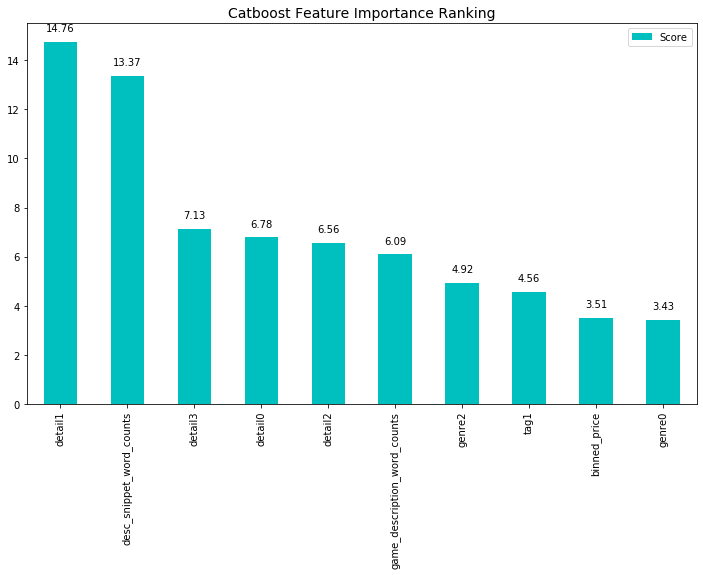

In [213]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score[:10].plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

It seems, that at least 2 of our basic text features actually helped to improve the result - that's a bit of a surprise for me, I was hoping for some of TfIdf to be in top

# Conclusion
In this part 2 we have worked mainly with text data:

1. Performed basic text tarsnformation
2. Generated basic features
3. Genrated advanced TfIdf advanced features
4. Rerun the moodel, analysed teh results and saw which new features contributed to the accuracy improvement
5. As a separate task, we performed topic extraction using TfIdf and NMF and LDA

Stay tuned for **part 3**, where we will try to build recommendation system (finally!) or fail trying :)

In [ ]:
## retrain model